In [ ]:
import pyemu
import flopy as fp
import os, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
org_d = Path('../pest_background_files/')
t_d = Path('../pest_ies_setup')

In [ ]:
if t_d.exists():
    shutil.rmtree(t_d)
shutil.copytree(org_d,t_d)
shutil.copytree('./pyemu',t_d / 'pyemu')

### get spatial reference for the model

In [ ]:
sim = fp.mf6.MFSimulation.load(sim_ws = str(t_d))
gwf = sim.get_model()

In [ ]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        str(t_d / "at.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)
sr

### set up variograms for K pilot points

In [ ]:
pp_aq = 3
# exponential variogram for spatially varying parameters
v_aq = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=pp_aq * 5 * sr.delc[0], # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
aq_gs = pyemu.geostats.GeoStruct(variograms=v_aq, transform='log') 

In [ ]:
# pp_clay=3
# # exponential variogram for spatially varying parameters
# v_clay = pyemu.geostats.ExpVario(contribution=1.0, #sill
#                                     a=pp_clay * 3 * sr.delc[0], # range of correlation; length units of the model. In our case 'meters'
#                                     anisotropy=1.0, #name says it all
#                                     bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
#                                     )

# # geostatistical structure for spatially varying parameters
# clay_gs = pyemu.geostats.GeoStruct(variograms=v_clay, transform='log') 

In [ ]:
ib = gwf.dis.idomain.array[0]


### we only need pilot points for two unique K files - k_aq and k_clay

In [ ]:
k_aq = np.loadtxt(t_d/'k_aq.ref')
k_clay = np.loadtxt(t_d/'k_clay.ref')


In [ ]:
uniq_aq = np.unique(k_aq)
aq_zones_dict = dict(zip(np.arange(1,len(uniq_aq)+1), uniq_aq))
aq_zones_dict

In [ ]:
uniq_clay = np.unique(k_clay)
clay_zones_dict = dict(zip(np.arange(1,len(uniq_clay)+1), uniq_clay))
clay_zones_dict

In [ ]:
clay_zones = np.zeros_like(k_aq)
for ck, cv in clay_zones_dict.items():
    clay_zones[k_clay==cv] = ck
plt.imshow(clay_zones)
plt.colorbar()

In [ ]:
clay_zones[clay_zones==2] = -1

### non pilot-point alternative for clay

In [ ]:
clay_zones = [list(i) for i in clay_zones]
clay_zones

In [ ]:
# make a template file
with open(t_d / 'k_clay.ref.tpl', 'w') as ofp:
    ofp.write('ptf ~\n')
    for line in clay_zones:
        [ofp.write('~  hk_clay   ~ ') if i == 1 else ofp.write(' 1 ') for i in line]
        ofp.write('\n')

In [ ]:
t_d

In [ ]:
aq_zones = np.zeros_like(k_aq)
for ck, cv in aq_zones_dict.items():
    aq_zones[k_aq==cv] = ck
plt.imshow(aq_zones)
plt.colorbar()

## let's set up pilot points for the k files

In [ ]:

aq_pp_df = pyemu.pp_utils.setup_pilotpoints_grid(sr=sr,  # model spatial reference
                                              ibound=aq_zones, # to which cells to setup ppoints
                                              prefix_dict={0:['hk_aq']}, #prefix to add to parameter names
                                              pp_dir=t_d, 
                                              tpl_dir=t_d, 
                                                 shapename=str(t_d / 'pp_aq.shp'),
                                                use_ibound_zones=True,
                                              every_n_cell=pp_aq) # pilot point spacing

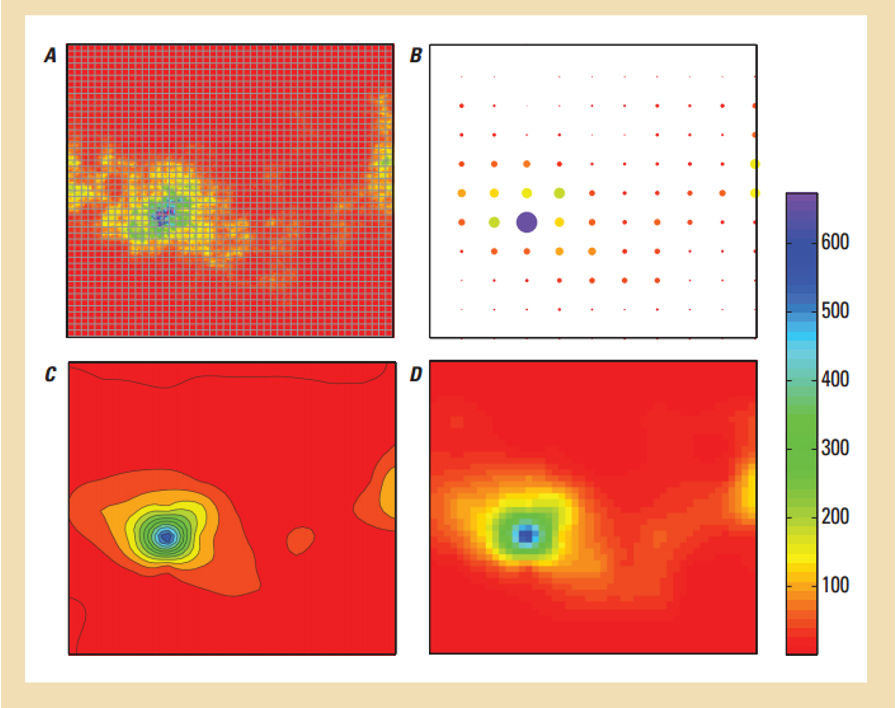

In [ ]:
plt.scatter(x=aq_pp_df.x,y=aq_pp_df.y, c=aq_pp_df.zone)
plt.axis('equal')

In [ ]:
# clay_pp_df = pyemu.pp_utils.setup_pilotpoints_grid(sr=sr,  # model spatial reference
#                                               ibound=clay_zones, # to which cells to setup ppoints
#                                               prefix_dict={0:['hk_clay']}, #prefix to add to parameter names
#                                               pp_dir=t_d, 
#                                               tpl_dir=t_d, 
#                                             shapename=str(t_d / 'pp_clay.shp'),
#                                                 use_ibound_zones=True,
#                                               every_n_cell=pp_clay,
#                                               ) # pilot point spacing

In [ ]:
# plt.scatter(x=clay_pp_df.x,y=clay_pp_df.y, c=clay_pp_df.zone)
# plt.axis('equal')

In [ ]:
list(t_d.glob('*.tpl'))

In [ ]:
list(t_d.glob('*.ins'))

In [ ]:
aq_pp_df.pargp

In [ ]:
ok_aq = pyemu.geostats.OrdinaryKrige(aq_gs,aq_pp_df.loc[aq_pp_df.pargp=='hk_aq'])
# ok_clay = pyemu.geostats.OrdinaryKrige(clay_gs,clay_pp_df.loc[clay_pp_df.pargp=='hk_clay'])


In [ ]:
aq_fac_df = ok_aq.calc_factors_grid(sr, minpts_interp=1,maxpts_interp=10, )
# clay_fac_df = ok_clay.calc_factors_grid(sr, minpts_interp=1,maxpts_interp=10, )


In [ ]:
ok_aq.to_grid_factors_file(str(t_d / 'pp_aq.fac'))
# ok_clay.to_grid_factors_file(str(t_d / 'pp_clay.fac'))


In [ ]:
list(t_d.glob('*.fac'))

In [ ]:
aq_fac_df

### now make a PST file

In [ ]:
cwd = Path(os.getcwd())
os.chdir(t_d)
pst = pyemu.Pst.from_io_files(*pyemu.helpers.parse_dir_for_io_files('.'))
os.chdir(cwd)

### set initial parameter values

In [ ]:
pars = pst.parameter_data

### first set constant parameter values

In [ ]:
pars.loc[pars.parnme.str.contains('aniso')]

In [ ]:
pars.loc['rv1', 'parval1'] = 1e+05
pars.loc['rv1', 'parlbnd'] = 1e+04
pars.loc['rv1', 'parubnd'] = 1e+06
pars.loc['rv1', 'pargp'] = 'riv_cond'

pars.loc['rch', 'parval1'] = 0.003641
pars.loc['rch', 'parlbnd'] = 0.003641*.8
pars.loc['rch', 'parubnd'] = 0.003641*1.2
pars.loc['rch', 'pargp'] = 'rch'

pars.loc['kaniso', 'parval1'] = 0.2
pars.loc['kaniso', 'parlbnd'] = 0.002
pars.loc['kaniso', 'parubnd'] = 0.8
pars.loc['kaniso', 'pargp'] = 'anisotropy'

pars.loc['kaniso_clay', 'parval1'] = 0.5
pars.loc['kaniso_clay', 'parlbnd'] = 0.002
pars.loc['kaniso_clay', 'parubnd'] = 0.8
pars.loc['kaniso_clay', 'pargp'] = 'anisotropy_clay'

### next group parameters by their arrays and zones

In [ ]:
pars.loc[~pars.zone.isnull(), 'pargp'] = [f"{i.split('_i:')[0]}_{int(float(z))}" for 
                                          i,z in zip(pars.loc[~pars.zone.isnull()].parnme,
                                                     pars.loc[~pars.zone.isnull()].zone)]

In [ ]:
pars.zone = [float(i) for i in pars.zone]

### Without enforcing too much structure, we can adjust a few starting values and bounds to inform ies of at least some of the general patterns of K values

In [ ]:
pars.loc[pars.pargp.str.contains('hk_aq'), 'parval1'] = 100
pars.loc[pars.pargp.str.contains('hk_aq'), 'parlbnd'] = .01
pars.loc[pars.pargp.str.contains('hk_aq'), 'parubnd'] = 1e4
pars.loc['hk_clay', 'pargp'] = 'hk_clay'
pars.loc[pars.pargp.str.contains('hk_clay'), 'parval1'] = 0.01
pars.loc[pars.pargp.str.contains('hk_clay'), 'parlbnd'] = .0001
pars.loc[pars.pargp.str.contains('hk_clay'), 'parubnd'] = 1e2
pars.loc[pars.pargp=='hk_aq_5', 'parval1'] = 500
pars.loc[pars.pargp=='hk_aq_4', 'parval1'] = 300
pars.loc[pars.pargp=='hk_aq_3', 'parval1'] = 150
pars.loc[pars.pargp=='hk_aq_4', 'parubnd'] = 1050
pars.loc[pars.pargp=='hk_aq_3', 'parubnd'] = 800


## read in the observation values and set them

In [ ]:
obsvals = pd.read_csv(t_d / 'obsvalues.dat', delim_whitespace=True, index_col=0)
obsvals

In [ ]:
pars

In [ ]:
for i in range(17):
    obsvals.loc[f'd_u{i+1:02d}_w{i+1:02d}', 'obsval'] = obsvals.loc[f'u{i+1:02d}'].obsval - \
                                                        obsvals.loc[f'w{i+1:02d}'].obsval
    obsvals.loc[f'd_u{i+1:02d}_w{i+1:02d}', 'weight'] = 1
    obsvals.loc[f'd_u{i+1:02d}_w{i+1:02d}', 'obgnme'] = 'head_diff'
    
obsvals.sample(5)

In [ ]:
pst.observation_data.sample(5)

In [ ]:
obsvals

In [ ]:
pst.observation_data.loc[obsvals.index,'obgnme'] = obsvals.obgnme
pst.observation_data.loc[obsvals.index,'obsval'] = obsvals.obsval
pst.observation_data.loc[obsvals.index,'weight'] = obsvals.weight
pst.observation_data.loc[pst.observation_data.obgnme=='rivgroup', 'weight'] = [np.abs(i) for i in 10 / \
    pst.observation_data.loc[pst.observation_data.obgnme=='rivgroup'].obsval]


pst.observation_data['standard_deviation']=[np.abs(i) for i in pst.observation_data.obsval.values*.1]
pst.observation_data.loc[pst.observation_data.obgnme=='headgroup', 'standard_deviation'] = .5


pst.observation_data.loc[pst.observation_data.obgnme=='lakegroup', 'standard_deviation'] = \
  pst.observation_data.loc[pst.observation_data.obgnme=='lakegroup'].obsval*.2
pst.observation_data.loc[pst.observation_data.obgnme=='head_diff', 'standard_deviation'] = 0.01
pst.observation_data.loc[pst.observation_data.obgnme=='head_diff', 'weight'] = 10.0

pst.observation_data.sample(10)


### now we need to write out the `forward_run` script that includes pilot point interpolation, running MF6, and postprocesses the observations to prepare them for reading

In [ ]:
with open(t_d / 'forward_run.py','w') as f:
    #add imports
    f.write("import os\nimport shutil\nimport numpy as np\nimport pyemu\nimport flopy\n")
    f.write("import pandas as pd\n")
    # preprocess pilot points to grid
    f.write("_ = pyemu.geostats.fac2real('hk_aqpp.dat', factors_file='pp_aq.fac',out_file='k_aq.ref')\n")
#     f.write("_ = pyemu.geostats.fac2real('hk_claypp.dat', factors_file='pp_clay.fac',out_file='k_clay.ref')\n")
    # run MF6
    f.write("pyemu.os_utils.run('mf6')\n")
    # process the observations
    f.write("outfiles = ['./riv.csv','./at.wt.csv','./chd.csv','./at.csv']\n")
    f.write("obs = pd.concat([pd.read_csv(i).T.iloc[1:] for i in outfiles])\n")
    f.write("for i in range(17):\n")
    f.write("    obs.loc[f'd_U{i+1:02d}_W{i+1:02d}', 0] = obs.loc[f'U{i+1:02d}'][0] - obs.loc[f'W{i+1:02d}'][0]\n")
    f.write("obs.columns=['obsname']\n")
    f.write('obs.to_csv("allobs.dat", sep = " ")')
    

### now set a few ies-specific values and write out the file

In [ ]:
pst.model_command = ['python forward_run.py']
pst.control_data.noptmax = 0
pst.pestpp_options['lambdas']=[0.01, 0.1,1,10,50,75,100]
pst.pestpp_options['ies_no_noise'] = False
pst.pestpp_options['ies_num_reals'] = 150
pst.pestpp_options['par_sigma_range'] = 6
pst.write(str(t_d / 'mv.ies.test.pst'), version=2)

### copy the run folder over to be a master for parallel runs

In [ ]:
rundir = Path('../tmprun')
if rundir.exists():
    shutil.rmtree(rundir)
shutil.copytree(t_d, rundir)

In [ ]:
pyemu.os_utils.run('pestpp-ies mv.ies.test.pst', str(rundir))

## now read in the PST file and check out the objective function balance

In [ ]:
pst = pyemu.Pst(str(rundir / 'mv.ies.test.pst'))

In [ ]:
pst.plot(kind='phi_pie')

In [ ]:
pst.phi_components

In [ ]:
newphi = {'headgroup': .3*pst.phi,
 'lakegroup': .3*pst.phi,
 'rivgroup': .2*pst.phi,
 'head_diff': .2*pst.phi}

In [ ]:
pst.adjust_weights(obsgrp_dict=newphi)

In [ ]:
pst.plot(kind='phi_pie')

In [ ]:
pst.control_data.noptmax = 3
pst.write(str(t_d / 'mv.ies.pst'), version=2)

In [ ]:
rundir = Path('../tmprun')
if rundir.exists():
    shutil.rmtree(rundir)
shutil.copytree(t_d, rundir)

### now run the parameter estimation in parallel

In [ ]:
run_flag = True
if run_flag:
    pyemu.os_utils.start_workers(str(t_d),num_workers=25, master_dir=str(rundir), 
                             exe_rel_path='pestpp-ies',
                            pst_rel_path='mv.ies.pst')